# Kernels in scikit-learn - Lab

## Introduction

In this lab, you'll explore applying several types of kernels on some more visual data. At the end of the lab, you'll then apply your knowledge of SVMs to a real-world dataset!

## Objectives

In this lab you will: 

- Create and evaluate a non-linear SVM model in scikit-learn using real-world data 
- Interpret the prediction results of an SVM model by creating visualizations 

## The data

To start, reexamine the final datasets from the previous lab: 

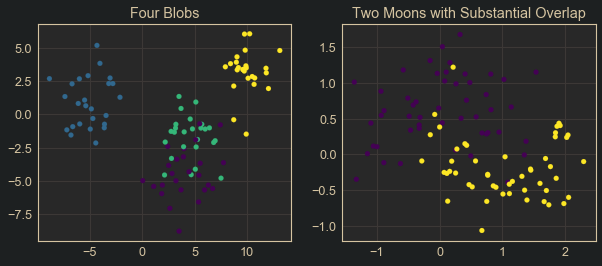

In [2]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline  
plt.style.use('ggplot')
from jupyterthemes import jtplot
jtplot.style()
from sklearn import svm
from sklearn.model_selection import train_test_split

import numpy as np

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('Four Blobs')
X_3, y_3 = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=1.6, random_state=123)
plt.scatter(X_3[:, 0], X_3[:, 1], c=y_3, s=25)

plt.subplot(122)
plt.title('Two Moons with Substantial Overlap')
X_4, y_4 = make_moons(n_samples=100, shuffle=False , noise=0.3, random_state=123)
plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, s=25)

plt.show()

## Explore the RBF kernel

Recall how a radial basis function kernel has 2 hyperparameters: `C` and `gamma`. To further investigate tuning, you'll generate 9 subplots with varying parameter values and plot the resulting decision boundaries. Take a look at this [example from scikit-learn](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) for inspiration. Each of the 9 plots should look like this:

![](images/SVM_rbf.png)

Note that the score represents the percentage of correctly classified instances according to the model. 

In [3]:
C_range = np.array([0.1, 1, 10])
gamma_range = np.array([0.1, 1, 100])
param_grid = dict(gamma=gamma_range, C=C_range)
details = []

# Create a loop that builds a model for each of the 9 combinations
for C in C_range:
    for gamma in gamma_range:
        clf = svm.SVC(C=C, gamma=gamma)
        clf.fit(X_4, y_4)
        details.append((C, gamma, clf))

In [6]:
# Prepare your data for plotting
X1_min, X1_max = X_4[:, 0].min() - 1, X_4[:, 0].max() + 1
X2_min, X2_max = X_4[:, 1].min() - 1, X_4[:, 1].max() + 1
X1_coord = np.linspace(X1_min, X1_max, 200)
X2_coord = np.linspace(X2_min, X2_max, 200)
X1_C, X2_C = np.meshgrid(X1_coord, X2_coord)

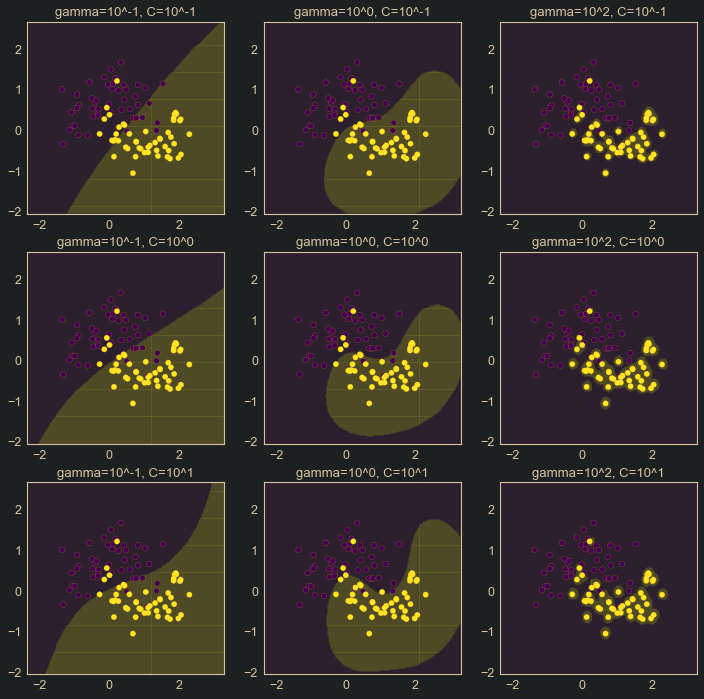

In [29]:
# Plot the prediction results in 9 subplots  
plt.figure(figsize=(12, 12))
for (k, (C, gamma, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.predict(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_range), len(gamma_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, Z, alpha=0.05
                   #cmap=plt.cm.RdBu
                  )
    plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, #cmap=plt.cm.RdBu_r,
                edgecolors='orange'
               )
    #plt.xticks(())
    #plt.yticks(())
    plt.axis('tight')

Repeat what you did before but now, use `decision_function()` instead of `predict()`. What do you see?

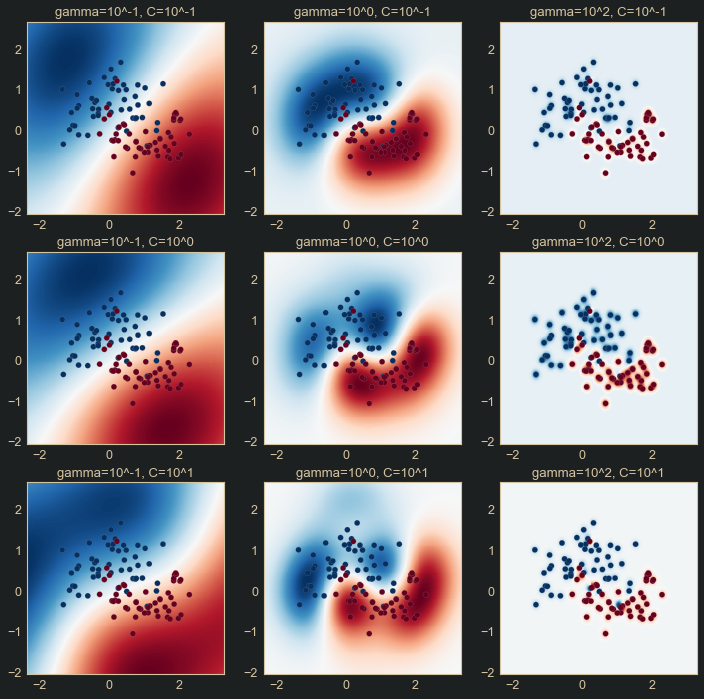

In [30]:
# Plot the decision function results in 9 subplots
plt.figure(figsize=(12, 12))
for (k, (C, gamma, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_range), len(gamma_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    #plt.xticks(())
    #plt.yticks(())
    plt.axis('tight')

In [ ]:
# I can see that the predictions across the grid are binary, so two solid colors fill the space,
# whereas with the decision_function we see gradations of color representing distance from the
# hyperplane

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import seaborn as sns

The best parameters are {'C': 10.0, 'gamma': 1.0} with a score of 0.89


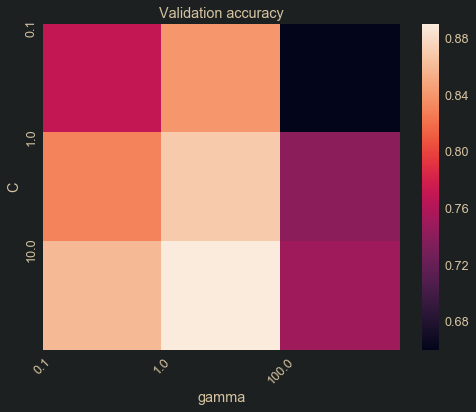

In [50]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_4, y_4)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(scores, ax=ax)
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
#           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
#plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

## Explore the Polynomial kernel

Recall that the polynomial kernel has 3 hyperparameters:
- $\gamma$, which can be specified using parameter `gamma`
- $r$, which can be specified using parameter `coef0`
- $d$, which can be specified using parameter `degree`

Build 8 different plots using all the possible combinations:
- $r= 0.1$ and $2$
- $\gamma= 0.1$ and $1$
- $d= 3$ and $4$

Note that `decision_function()` cannot be used on a classifier with more than two classes, so simply use `predict()` again.

In [67]:
r_range =  np.array([0.1, 2])
gamma_range =  np.array([0.1, 1])
d_range = np.array([3, 4])
param_grid = dict(gamma=gamma_range, degree=d_range, coef0=r_range)
details = []

# Create a loop that builds a model for each of the 8 combinations
for r in r_range:
    for gamma in gamma_range:
        for d in d_range:
            clf = svm.SVC(kernel='poly', coef0=r, degree=d, gamma=gamma)
            clf.fit(X_4, y_4)
            details.append((r, gamma, d, clf))

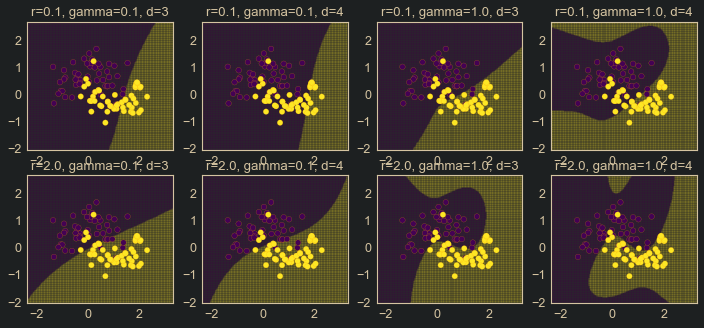

In [68]:
# Plot the prediction results in 8 subplots  
plt.figure(figsize=(12, 8))
for (k, (r, gamma, d, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.predict(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_range), len(gamma_range)*len(r_range), k + 1)
    plt.title("r={}, gamma={}, d={}".format(r, gamma, d),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, Z, alpha=0.05
                   #cmap=plt.cm.RdBu
                  )
    plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, #cmap=plt.cm.RdBu_r,
                edgecolors='orange'
               )
    #plt.xticks(())
    #plt.yticks(())
    plt.axis('tight')

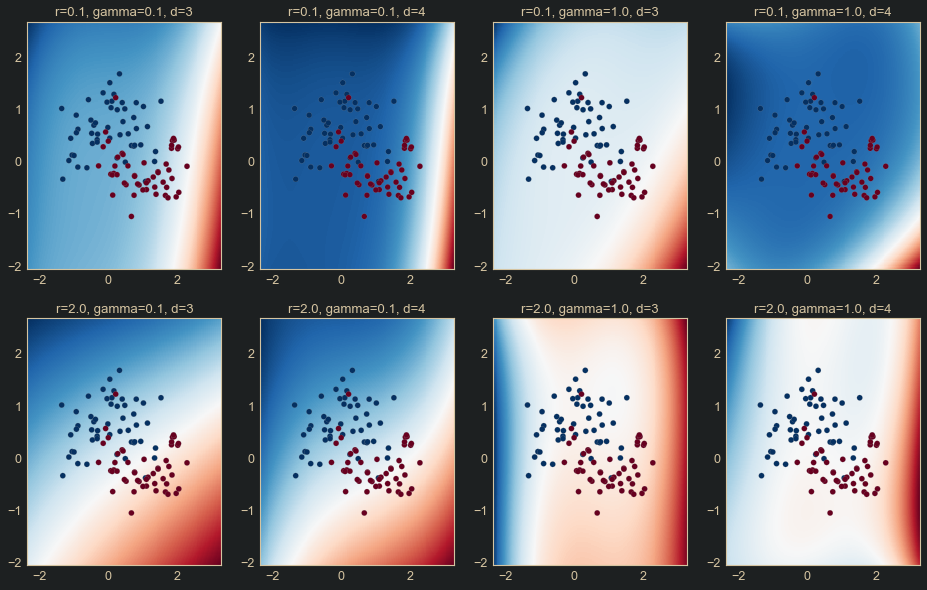

In [69]:
# Plot the decision function results in 9 subplots
plt.figure(figsize=(16, 10))
for (k, (r, gamma, d, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(d_range), len(gamma_range)*len(r_range), k + 1)
    plt.title("r={}, gamma={}, d={}".format(r, gamma, d),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    #plt.xticks(())
    #plt.yticks(())
    plt.axis('tight')

The best parameters are {'coef0': 0.1, 'degree': 3, 'gamma': 1.0} with a score of 0.87


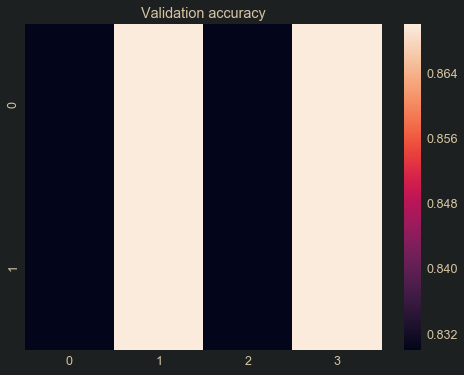

In [74]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_4, y_4)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(d_range),
                                                     len(gamma_range)*len(r_range))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(scores, ax=ax)
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
#           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
#plt.xlabel('gamma')
#plt.ylabel('C')
#plt.colorbar()
#plt.xticks(gamma_range, rotation=45)
#plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [ ]:
# This kernel has gotten an accuracy score slightly lower than we got from the RBF kernel

## The Sigmoid kernel

Build a support vector machine using the Sigmoid kernel.

Recall that the sigmoid kernel has 2 hyperparameters:
- $\gamma$, which can be specified using parameter `gamma`
- $r$, which can be specified using parameter `coef0`


Look at 9 solutions using the following values for $\gamma$ and $r$.

- $\gamma$= 0.001, 0.01, and 0.1
- $r$ = 0.01, 1, and 10

In [75]:
gamma_range = [0.001, 0.01, 0.1]
r_range = [0.01, 1, 10]
param_grid = dict(gamma=gamma_range, coef0=r_range)
details = []
# Create a loop that builds a model for each of the 9 combinations
for gamma in gamma_range:
    for r in r_range:
        clf = svm.SVC(kernel='sigmoid', gamma=gamma, coef0=r)
        clf.fit(X_4, y_4)
        details.append((gamma, r, clf))

In [76]:
# Prepare your data for plotting


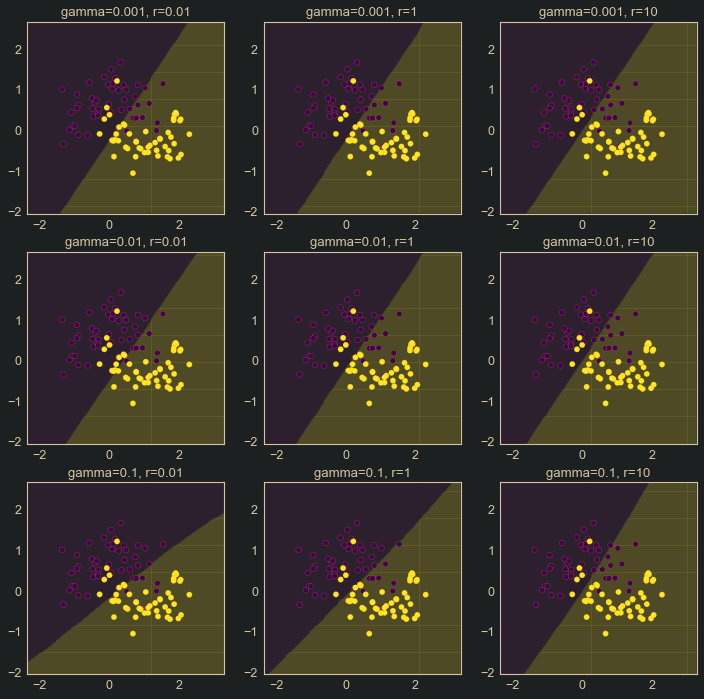

In [77]:
# Plot the prediction results in 9 subplots  
plt.figure(figsize=(12, 12))
for (k, (gamma, r, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.predict(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(gamma_range), len(r_range), k + 1)
    plt.title("gamma={}, r={}".format(gamma, r),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, Z, alpha=0.05
                   #cmap=plt.cm.RdBu
                  )
    plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, #cmap=plt.cm.RdBu_r,
                edgecolors='orange'
               )
    #plt.xticks(())
    #plt.yticks(())
    plt.axis('tight')

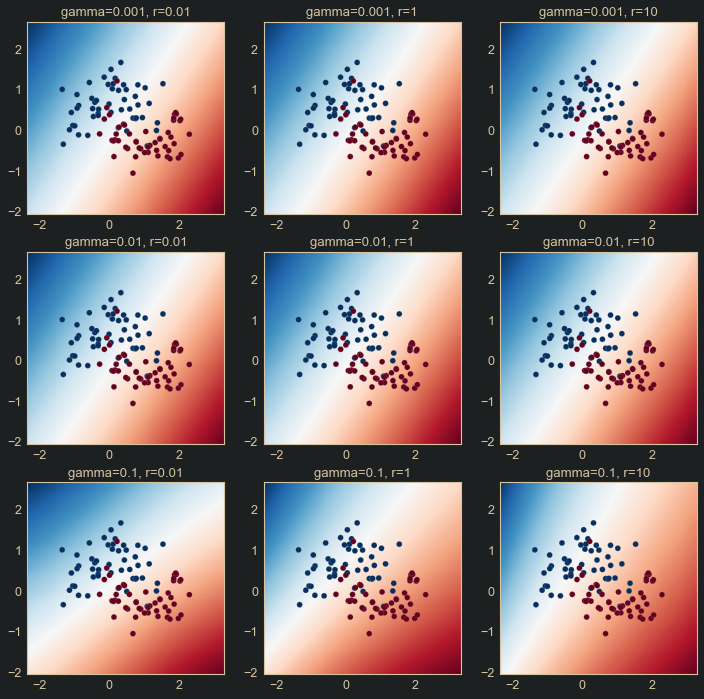

In [78]:
# Plot the decision function results in 9 subplots
plt.figure(figsize=(12, 12))
for (k, (gamma, r, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(gamma_range), len(r_range), k + 1)
    plt.title("gamma={}, r={}".format(gamma, r),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_4[:, 0], X_4[:, 1], c=y_4, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    #plt.xticks(())
    #plt.yticks(())
    plt.axis('tight')

The best parameters are {'coef0': 0.01, 'gamma': 0.1} with a score of 0.83


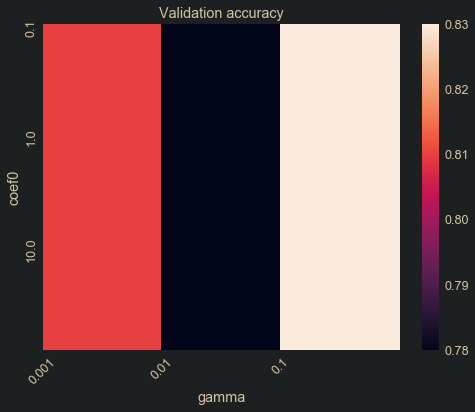

In [80]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_4, y_4)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(scores, ax=ax)
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
#           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('coef0')
#plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

## What is your conclusion here?

- The polynomial kernel is very sensitive to the hyperparameter settings. Especially when setting a "wrong" gamma - this can have a dramatic effect on the model performance
- Our experiments with the Polynomial kernel were more successful

In [81]:
# The RBF kernel has given us the best results so far, but the polynomial was a close second.
# The Sigmoid kernel underperformed both of the others in this test

## Explore the Polynomial kernel again, with a train-test split

Explore the same parameters you did before when exploring polynomial kernel 

- Perform a train-test split. Assign 33% of the data to the test set and set the `random_state` to 123 
- Train 8 models using the training set for each combination of different parameters 
- Plot the results as above, both for the training and test sets 
- Make some notes for yourself on training vs test performance and select an appropriate model based on these results 

In [82]:
from sklearn.metrics import accuracy_score

In [87]:
# Perform a train-test split, then create a loop that builds a model for each of the 8 combinations
X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.33, random_state=123)

# Create a loop that builds a model for each of the 8 combinations
r_range =  np.array([0.1, 2])
gamma_range =  np.array([0.1, 1]) 
d_range = np.array([3, 4])
param_grid = dict(gamma=gamma_range, coef0=r_range, degree=d_range)
details = []
train_scores = []
test_scores = []

for r in r_range:
    for gamma in gamma_range:
        for d in d_range:
            print('Params: r = {}, gamma = {}, d = {}'.format(r, gamma, d))
            clf = svm.SVC(gamma=gamma, coef0=r, degree=d)
            clf.fit(X_train, y_train)
            train_pred = clf.predict(X_train)
            score = accuracy_score(y_train, train_pred)
            train_scores.append(score)
            print('Train Accuracy:', score)
            test_pred = clf.predict(X_test)
            score = accuracy_score(y_test, test_pred)
            test_scores.append(score)
            print('Test Accuracy:', score)
            details.append((r, gamma, d, clf))
            
train_scores = np.array(train_scores)
high_train = np.argmax(train_scores)
test_scores = np.array(test_scores)
high_test = np.argmax(test_scores)
print('Highest train score {} with params: r = {}, gamma = {}, d = {}'.format(
    train_scores[high_train],
    details[high_train][0],
    details[high_train][1],
    details[high_train][2]
    )
)
print('Highest test score {} with params: r = {}, gamma = {}, d = {}'.format(
    test_scores[high_test],
    details[high_test][0],
    details[high_test][1],
    details[high_test][2]
))

Params: r = 0.1, gamma = 0.1, d = 3
Train Accuracy: 0.8208955223880597
Test Accuracy: 0.8181818181818182
Params: r = 0.1, gamma = 0.1, d = 4
Train Accuracy: 0.8208955223880597
Test Accuracy: 0.8181818181818182
Params: r = 0.1, gamma = 1.0, d = 3
Train Accuracy: 0.8656716417910447
Test Accuracy: 0.9393939393939394
Params: r = 0.1, gamma = 1.0, d = 4
Train Accuracy: 0.8656716417910447
Test Accuracy: 0.9393939393939394
Params: r = 2.0, gamma = 0.1, d = 3
Train Accuracy: 0.8208955223880597
Test Accuracy: 0.8181818181818182
Params: r = 2.0, gamma = 0.1, d = 4
Train Accuracy: 0.8208955223880597
Test Accuracy: 0.8181818181818182
Params: r = 2.0, gamma = 1.0, d = 3
Train Accuracy: 0.8656716417910447
Test Accuracy: 0.9393939393939394
Params: r = 2.0, gamma = 1.0, d = 4
Train Accuracy: 0.8656716417910447
Test Accuracy: 0.9393939393939394
Highest train score 0.8656716417910447 with params: r = 0.1, gamma = 1.0, d = 3
Highest test score 0.9393939393939394 with params: r = 0.1, gamma = 1.0, d = 3


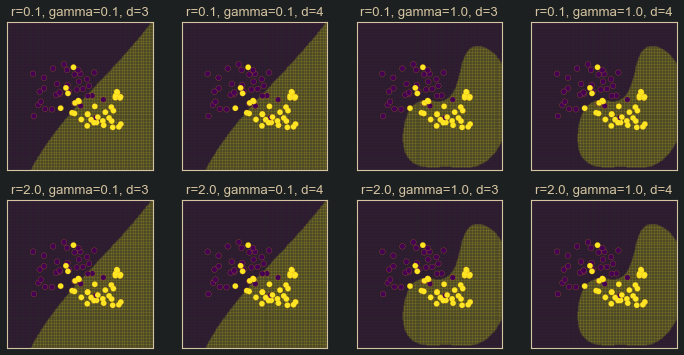

In [101]:
# Plot the prediction results in 8 subplots on the training set
plt.figure(figsize=(12, 6))
for (k, (r, gamma, d, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.predict(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(d_range), len(gamma_range)*len(r_range), k + 1)
    plt.title("r={}, gamma={}, d={}".format(r, gamma, d),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, Z, alpha=0.05
                   #cmap=plt.cm.RdBu
                  )
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, #cmap=plt.cm.RdBu_r,
                edgecolors='orange'
               )
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

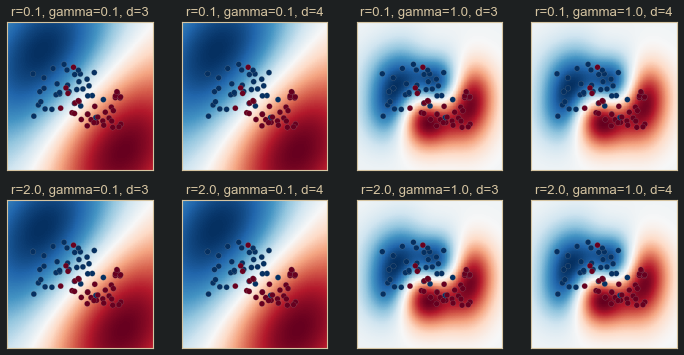

In [103]:
# Plot the decision function on the training set
plt.figure(figsize=(12, 6))
for (k, (r, gamma, d, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(d_range), len(gamma_range)*len(r_range), k + 1)
    plt.title("r={}, gamma={}, d={}".format(r, gamma, d),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

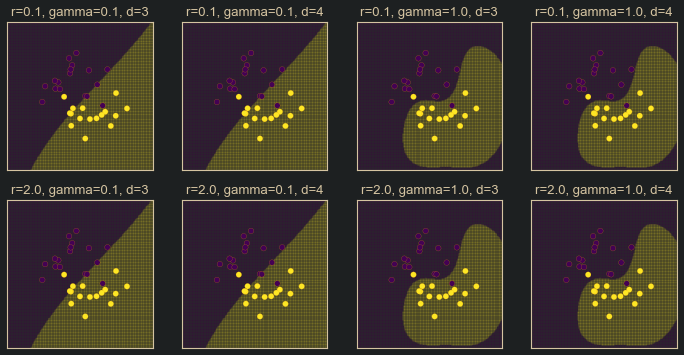

In [104]:
# Plot the prediction results in 8 subplots on the test set
plt.figure(figsize=(12, 6))
for (k, (r, gamma, d, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.predict(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(d_range), len(gamma_range)*len(r_range), k + 1)
    plt.title("r={}, gamma={}, d={}".format(r, gamma, d),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, Z, alpha=0.05
                   #cmap=plt.cm.RdBu
                  )
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, #cmap=plt.cm.RdBu_r,
                edgecolors='orange'
               )
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

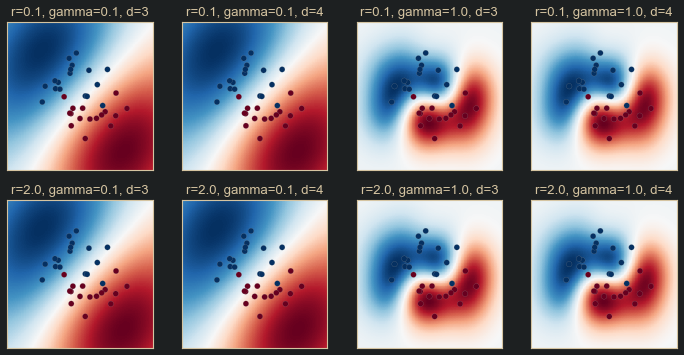

In [105]:
# Plot the decision function
plt.figure(figsize=(12, 6))
for (k, (r, gamma, d, clf)) in enumerate(details):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[X1_C.ravel(), X2_C.ravel()])
    Z = Z.reshape(X1_C.shape)

    # visualize decision function for these parameters
    plt.subplot(len(d_range), len(gamma_range)*len(r_range), k + 1)
    plt.title("r={}, gamma={}, d={}".format(r, gamma, d),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(X1_C, X2_C, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

The best parameters are {'coef0': 0.1, 'degree': 3, 'gamma': 1.0} with a score of 0.87


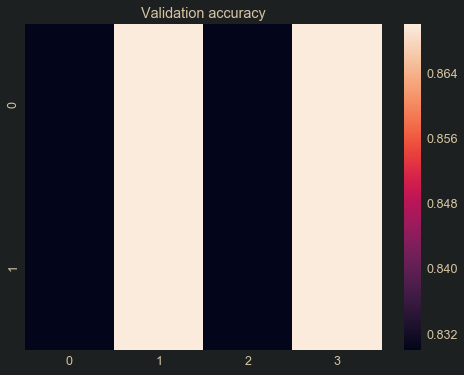

In [106]:
# Seeing if our results agree with a k fold cross validation average score
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_4, y_4)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
scores = grid.cv_results_['mean_test_score'].reshape(len(d_range),
                                                     len(gamma_range)*len(r_range))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(scores, ax=ax)
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
#           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
#plt.xlabel('gamma')
#plt.ylabel('C')
#plt.colorbar()
#plt.xticks(gamma_range, rotation=45)
#plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

## A higher-dimensional, real-world dataset

Until now, you've only explored datasets with two features to make it easy to visualize the decision boundary. Remember that you can use Support Vector Machines on a wide range of classification datasets, with more than two features. While you will no longer be able to visually represent decision boundaries (at least not if you have more than three feature spaces), you'll still be able to make predictions.

To do this, you'll use the salaries dataset again (in `'salaries_final.csv'`). 

This dataset has six predictors:

- `Age`: continuous 

- `Education`: Categorical - Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool 

- `Occupation`: Categorical - Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces 

- `Relationship`: Categorical - Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried 

- `Race`: Categorical - White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black 

- `Sex`: Categorical - Female, Male 

Simply run the code below to import and preview the dataset. 

In [107]:
import statsmodels as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
salaries = pd.read_csv('salaries_final.csv', index_col=0)
salaries.head()

,Age,Education,Occupation,Relationship,Race,Sex,Target
0,39,Bachelors,Adm-clerical,Not-in-family,White,Male,<=50K
1,50,Bachelors,Exec-managerial,Husband,White,Male,<=50K
2,38,HS-grad,Handlers-cleaners,Not-in-family,White,Male,<=50K
3,53,11th,Handlers-cleaners,Husband,Black,Male,<=50K
4,28,Bachelors,Prof-specialty,Wife,Black,Female,<=50K


The following cell creates dummy variables for all categorical columns and splits the data into target and predictor variables. 

In [108]:
# Create dummy variables and 
# Split data into target and predictor variables
target = pd.get_dummies(salaries['Target'], drop_first=True)
xcols = salaries.columns[:-1]
data = pd.get_dummies(salaries[xcols], drop_first=True)

Now build a simple linear SVM using this data. Note that using SVC, some slack is automatically allowed, so the data doesn't have to perfectly linearly separable.

- Create a train-test split of 75-25. Set the `random_state` to 123 
- Standardize the data
- Fit an SVM model, making sure that you set "probability = True"
- After you run the model, calculate the classification accuracy score on both the test set

In [111]:
# Split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=123)

In [112]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

> Warning: It takes quite a while to build the model! The score is slightly better than the best result obtained using decision trees, but at the cost of computational resources. Changing kernels can make computation times even longer.

In [124]:
y_train.values.reshape(1, -1)[0].shape

(24420,)

In [125]:
# Fit SVM model  
# ⏰ This cell may take several minutes to run
# setting probability to true will make it take even longer
clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train.values.reshape(1, -1)[0])

SVC(kernel='linear', probability=True)

In [126]:
# Calculate the classification accuracy score
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)
train_score = accuracy_score(y_train, train_pred)
test_score = accuracy_score(y_test, test_pred)
print('Train Accuracy Score:', train_score)
print('Test Accuracy Score:', test_score)

Train Accuracy Score: 0.8203521703521703
Test Accuracy Score: 0.8168529664660361


In [127]:
clf

True

In [131]:
X_train

,Age,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,Education_Assoc-acdm,Education_Assoc-voc,Education_Bachelors,...,Relationship_Not-in-family,Relationship_Other-relative,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male
6955,27,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
5054,21,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
8568,45,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
7830,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
22532,56,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,55,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
17730,33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
28030,19,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
15725,23,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1


In [134]:
clf.predict([X_train.iloc[0]])

array([0], dtype=uint8)

In [132]:
# Checking probability for a point
clf.predict_proba([X_train.iloc[0]])

array([[0.78264883, 0.21735117]])

In [133]:
clf.decision_function([X_train.iloc[0]])

array([-1.0018988])

## Summary

Great, you've got plenty of practice with Support Vector Machines! In this lab, you explored kernels and applying SVMs to real-life data!